# Urban Simulation Assessment code

In [1]:
%reset -f

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import numpy as np

## Part 1: London's underground resilience

In [3]:
# Reading in the network data
G = nx.read_graphml('london.graph.xml')

In [4]:
# Checking data
print(nx.info(G))
list(G.nodes(data = True))[0]

Graph with 401 nodes and 467 edges


('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [5]:
# Fixing the data type
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [6]:
# To check node attributes:
list(G.nodes(data = True))[0:3]

[('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)}),
 ('Kingsbury', {'coords': (519359.9688603217, 188721.22027255083)}),
 ('Queensbury', {'coords': (518811.3613368616, 189760.50737704366)})]

In [7]:
# To check edge attributes:
list(G.edges(data = True))[0:3]

[('Wembley Park',
  'Kingsbury',
  {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356}),
 ('Wembley Park',
  'Neasden',
  {'length': 2353.1659381957816, 'line_name': 'Jubilee', 'flows': 6744}),
 ('Wembley Park',
  'Preston Road',
  {'length': 1419.7351657633037, 'line_name': 'Metropolitan', 'flows': 36601})]

In [8]:
# Remove Nine Elms and Battersea Park
G.remove_node('Nine Elms')
G.remove_node('Battersea Park')

In [9]:
# Add inverse flow:
inv_flows={(e1, e2):(round(1./flows,7)) for e1, e2, flows in G.edges(data='flows')}

# Let us add the inversed flows as an attribute to the edges in the graph
nx.set_edge_attributes(G, inv_flows, 'inv_flows')

# Print edge list with attributes
list(G.edges(data = True))[0:3]

[('Wembley Park',
  'Kingsbury',
  {'length': 2916.7715580506483,
   'line_name': 'Jubilee',
   'flows': 12356,
   'inv_flows': 8.09e-05}),
 ('Wembley Park',
  'Neasden',
  {'length': 2353.1659381957816,
   'line_name': 'Jubilee',
   'flows': 6744,
   'inv_flows': 0.0001483}),
 ('Wembley Park',
  'Preston Road',
  {'length': 1419.7351657633037,
   'line_name': 'Metropolitan',
   'flows': 36601,
   'inv_flows': 2.73e-05})]

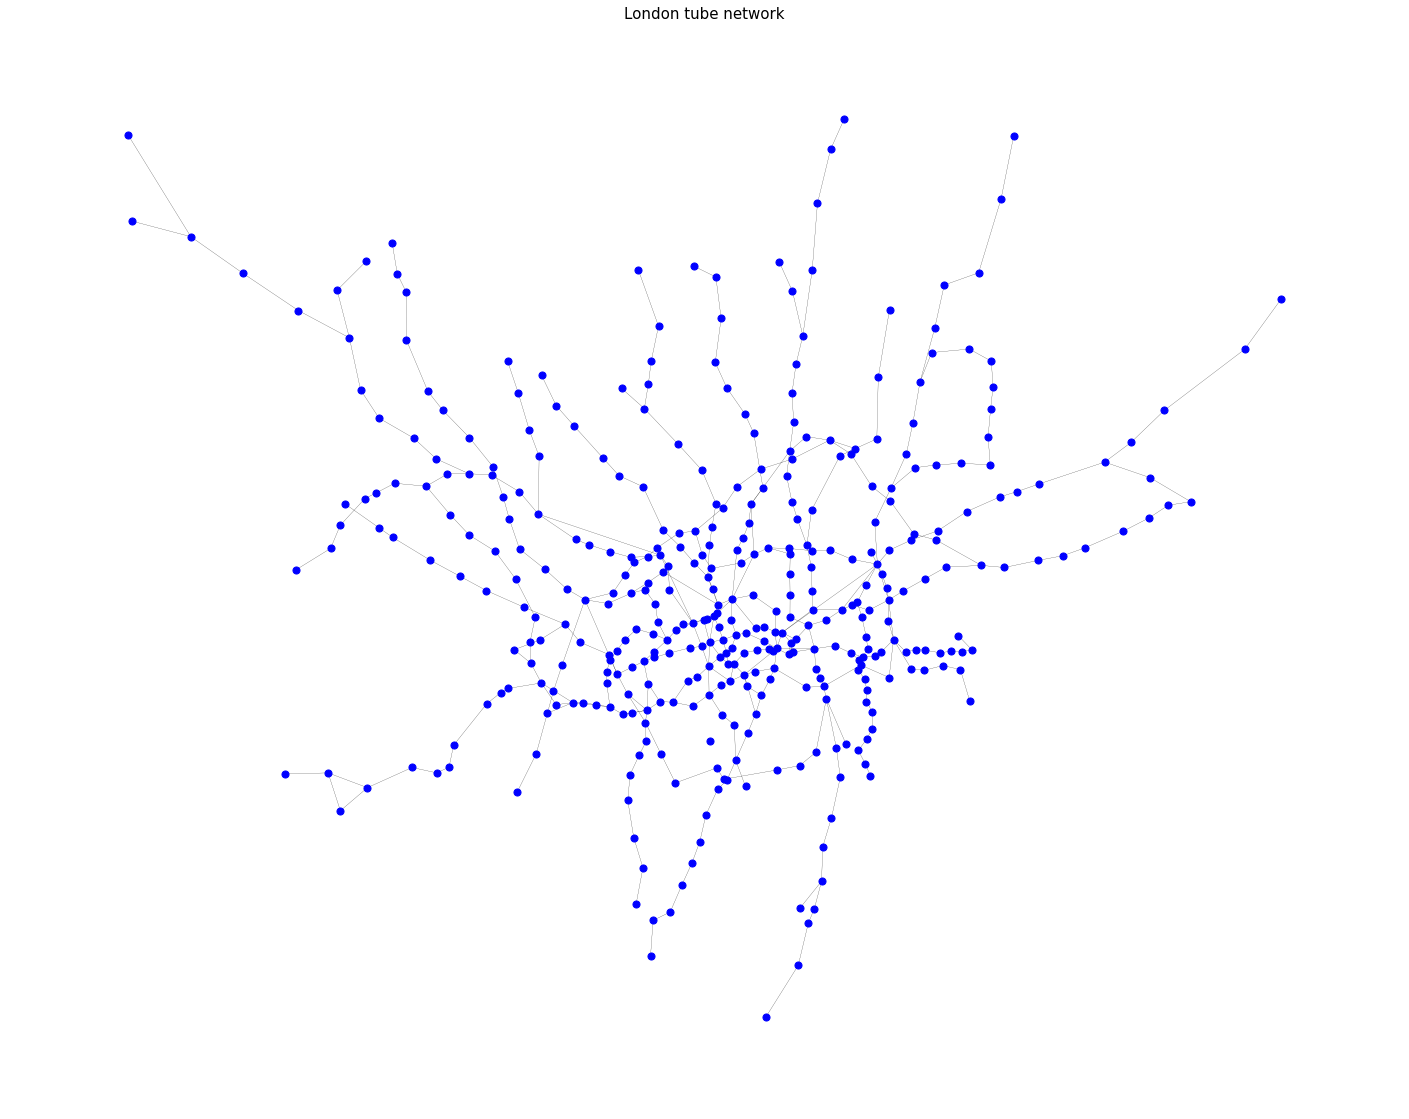

In [10]:
# Final check

#Setting up the positioning
fig, ax = plt.subplots(figsize=(25,20))
pos = nx.get_node_attributes(G, 'coords')
#Setting up the labels
node_labels = nx.get_node_attributes(G, 'station_name')

#Plot
nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

### I. Topological network
This part models London's underground as a topological (unweighted) network

#### I.1. Centrality measures
**Definitions from: Latora and Marchiori - 2007 - A measure of centrality based on network efficiency**
- Measure 1: degree centrality
- Measure 2: (topological) closeness centrality
- Measure 3: (topological) betweenness centrality

| Centrality measure | Definition | Equation for node ${i}$ (normalised) | Meaning for London underground | Importance for London underground
| :- | :- | :-: | :- | :- |
| Degree centrality (DC) | Number of direct ties a node has, normalised by potential neighbour count | ${C}^{D}_{i}=\frac{{k}_{i}}{N-1}$ <br> where ${k}_{i}$ is the number of direct ties| Number of stations directly connected to a node ${i}$ | Higher ${C}^{D}_{i}$ implies that connection between lines occur at that station, so the shut-down of the station likely causes large disruption requiring users to find other ways to switch lines and more lines to adjust their train schedules
| Closeness centrality (CC) | Reciprocal of the average distance from a node to all the other nodes | ${C}^{C}_{i}=\frac{N-1}{\sum{{d}_{ij}}}$ <br> where ${j}\neq{i}$ | How accessible a station is to all the rest of the stations, defined by the shortest path length | Higher ${C}^{C}_{i}$ implies that the station is easily accessible and therefore well-located for living and work, so the shut-down of the station likely causes inconvenience directly to a large number of people who aim to reach this station, having to find alternative routes
| Betweenness centrality (BC) | Number of geodesic linking two other nodes passing through a node ${i}$, normalised by the number of geodesic path in the network | ${C}^{B}_{i}=\frac{\sum{\sum{{n}_{jk}({i})}/{n}_{jk}}}{(N-1)(N-2)}$ <br> where ${j}\neq{i}$ and ${k}\neq{i}$, ${k}\neq{j}$ | How likely users go through this station when trying to reach a station from another, asuming equal probability for all stations to be the origin and destination | Higher ${C}^{B}_{i}$ implies higher chance of the station usage when trying to get from one station to another, so the shut-down of the station likely require more travels to opt for less efficient travel routes

*Table 1. Centrality measure summary, where ${N}$ is the total node count in London underground*

In [11]:
# Computing each measures - degree centrality
degree_dict =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree_dict),'degree')

In [12]:
# Computing each measures - closeness centrality
closeness_t_dict =nx.closeness_centrality(G)
nx.set_node_attributes(G,dict(closeness_t_dict),'closeness_t')

In [13]:
# Computing each measures - betweenness centrality
betweenness_t_dict =nx.betweenness_centrality(G)
nx.set_node_attributes(G,dict(betweenness_t_dict),'betweenness_t')

In [14]:
# Creating a dataframe with station name and 3 centrality measures
df = pd.DataFrame()
df['station_name'] = G.nodes()
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
df['topological closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
df['topological betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

In [15]:
# Check the top 10 for degree centrality
df_sorted_deg = df.sort_values(["degree"], ascending=False)
df_sorted_deg[['station_name', 'degree']][0:11]

,station_name,degree
Stratford,Stratford,0.022613
Bank and Monument,Bank and Monument,0.020101
King's Cross St. Pancras,King's Cross St. Pancras,0.017588
Baker Street,Baker Street,0.017588
Earl's Court,Earl's Court,0.015075
Oxford Circus,Oxford Circus,0.015075
Liverpool Street,Liverpool Street,0.015075
Waterloo,Waterloo,0.015075
Green Park,Green Park,0.015075
Canning Town,Canning Town,0.015075


In [16]:
# Check the top 10 for topological closeness centrality
df_sorted_clos = df.sort_values(["topological closeness"], ascending=False)
df_sorted_clos[['station_name', 'topological closeness']][0:10]

,station_name,topological closeness
Green Park,Green Park,0.114253
King's Cross St. Pancras,King's Cross St. Pancras,0.113208
Bank and Monument,Bank and Monument,0.112982
Westminster,Westminster,0.111992
Waterloo,Waterloo,0.111644
Oxford Circus,Oxford Circus,0.110770
Bond Street,Bond Street,0.110553
Farringdon,Farringdon,0.110430
Angel,Angel,0.110430
Moorgate,Moorgate,0.109818


In [17]:
# Check the top 10 for topological closeness centrality
df_sorted_bet = df.sort_values(["topological betweenness"], ascending=False)
df_sorted_bet[0:10]

,station_name,degree,topological closeness,topological betweenness
Stratford,Stratford,0.022613,0.103965,0.298351
Bank and Monument,Bank and Monument,0.020101,0.112982,0.288474
Liverpool Street,Liverpool Street,0.015075,0.109757,0.270703
King's Cross St. Pancras,King's Cross St. Pancras,0.017588,0.113208,0.256646
Waterloo,Waterloo,0.015075,0.111644,0.236992
Green Park,Green Park,0.015075,0.114253,0.213964
Euston,Euston,0.012563,0.109544,0.209004
Westminster,Westminster,0.010050,0.111992,0.200884
Baker Street,Baker Street,0.017588,0.108583,0.191711
Finchley Road,Finchley Road,0.010050,0.102300,0.165258


##### Output table:

| Rank | Degree centrality || Closeness centrality || Betweenness centrality ||
| -: | -: | :- | -: | :- | -: | :- |
| <b>1</b> | Stratford | 0.0225 | Green Park | 0.1148 | Stratford | 0.2978 |
| <b>2</b> | Bank and Monument  | 0.0200 | Bank and Monument | 0.1136 | Bank and Monument | 0.2905 |
| <b>3</b> | King's Cross St. Pancras | 0.0175 | King's Cross St. Pancras | 0.1134 | Liverpool Street | 0.2708 |
| <b>4</b> | Baker Street | 0.0175 | Westminster | 0.1125 | King's Cross St. Pancras | 0.2553 |
| <b>5</b> | Earl's Court | 0.0150 | Waterloo | 0.1123 | Waterloo | 0.2439 |
| <b>6</b> | Oxford Circus | 0.0150 | Oxford Circus | 0.1112 | Gren Park |0.2158 |
| <b>7</b> | Liverpool Street | 0.0150 | Bond Street | 0.1110 | Euston | 0.2083 |
| <b>8</b> | Waterloo | 0.0150 | Farringdon | 0.1107 | Westminster | 0.2033 |
| <b>9</b> | Green Park | 0.0150 | Angel | 0.1107 | Baker Street | 0.1916 |
| <b>10</b> | Canning Town | 0.0150 | Moorgate | 0.1103 | Finchley Road | 0.1651 |
| <b>11</b> | West Ham | 0.0150 | - | - | - | - |

*Table 2. Centrality measure computed results*

#### I.2. Impact measures - refer to word doc
- Number of stations in the largest component
- Average shortest path per station in the largest component

In [18]:
def maxsize_comp(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    return G_maxsub.number_of_nodes()

In [19]:
def avg_length(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    return nx.average_shortest_path_length(G_maxsub)

In [20]:
maxsize_comp(G)

398

In [21]:
avg_length(G)

13.567155677632496

(Removed -->)
<!--
**Definitions from: Efficiency measure_Latora and Marchiori (2001)_Efficient Behavior of Small-World Networks**
- Measure 1: Local efficiency - returns the average local efficiency of the graph. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.local_efficiency.html#networkx.algorithms.efficiency_measures.local_efficiency
- Measure 2: Global efficiency - returns the average global efficiency of the graph. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.global_efficiency.html#networkx.algorithms.efficiency_measures.global_efficiency
-->

In [22]:
'''
def global_efficiency_weighted(G):
    n = len(G)
    d_sum = 0
    denom = n * (n - 1)
    #shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = 'inv_flows'))
    shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = None))

    for u in range(0, n):
        for key in shortest_paths[u][1]:
            d_sum = d_sum + (1/shortest_paths[u][1][key] if shortest_paths[u][1][key] !=0 else 0)
    
    g_eff = d_sum/ denom
    return g_eff
'''

"\ndef global_efficiency_weighted(G):\n    n = len(G)\n    d_sum = 0\n    denom = n * (n - 1)\n    #shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = 'inv_flows'))\n    shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = None))\n\n    for u in range(0, n):\n        for key in shortest_paths[u][1]:\n            d_sum = d_sum + (1/shortest_paths[u][1][key] if shortest_paths[u][1][key] !=0 else 0)\n    \n    g_eff = d_sum/ denom\n    return g_eff\n"

#### I.3. Node removal

In [23]:
# centrality: 'degree', 'closeness_t', or 'betweenness_t'
def node_removal(centrality:str, sequential: bool)->tuple:

    # Initialise the output dataframe
    df_sub = []
    
    # Copy the graph for this
    G_rm = G.copy()

    # Initiate a list to store impact measures
    list_num_comp = []
    list_maxsize_comp = []
    list_avg_length = []
    list_avg_length_per_node = []

    # Initial impact measures
    list_num_comp.append(nx.number_connected_components(G_rm))
    list_maxsize_comp.append(maxsize_comp(G_rm))
    list_avg_length.append(avg_length(G_rm))
    list_avg_length_per_node.append(avg_length(G_rm)/maxsize_comp(G_rm))

    # Loop - repeat for 10 nodes
    for i in range(10):

        if sequential: # Re-calculate centrality
            degree_dict =nx.degree_centrality(G_rm)
            closeness_t_dict =nx.closeness_centrality(G_rm)
            betweenness_t_dict =nx.betweenness_centrality(G_rm)
            nx.set_node_attributes(G_rm,dict(degree_dict),'degree')
            nx.set_node_attributes(G_rm,dict(closeness_t_dict),'closeness_t')
            nx.set_node_attributes(G_rm,dict(betweenness_t_dict),'betweenness_t')
            #print("centrality re-calculated")
            
        # Identify the max centrality node(s)
        centrality_list=[(i[1][centrality]) for i in G_rm.nodes(data=True)]
        max_node=[n for n in G_rm.nodes() if G_rm.nodes[n][centrality] == max(centrality_list)][0] # If multiple max centrality nodes, choose one
        station_name = [key for key, value in G_rm.nodes(data=True) if G_rm.nodes[key][centrality] == max(centrality_list)][0]
        #print("max centrality to be removed:", max(centrality_list))
        #print("node name to be removed:", station_name)
            
        # Remove the node
        G_rm.remove_node(max_node)

        # Evaluate the network efficiency
        list_num_comp.append(nx.number_connected_components(G_rm))
        list_maxsize_comp.append(maxsize_comp(G_rm))
        list_avg_length.append(avg_length(G_rm))
        list_avg_length_per_node.append(avg_length(G_rm)/maxsize_comp(G_rm))
    
    print('Number of components in the graph: ', list_num_comp)
    print('Number of nodes in the largest component: ', list_maxsize_comp) 
    print('Average shortest path of the largest component: ', list_avg_length)
    print('Average shortest path per node of the largest component: ', list_avg_length_per_node)
    
    # Adding the results to the output dataframe
    df_sub = pd.DataFrame(zip(list_num_comp, list_maxsize_comp, list_avg_length, list_avg_length_per_node), 
                          columns = ['#components', 'maxsize', 'avlength', 'avlength per node'])
        
    return(df_sub)
    

#### Strategy A: non-sequential removal of 10 most impoartant nodes (one by one)

Degree centrality

In [24]:
df_degree_A = node_removal('degree', False)
#df_degree_A

Number of components in the graph:  [2, 4, 4, 4, 5, 6, 9, 9, 9, 10, 11]
Number of nodes in the largest component:  [398, 376, 375, 374, 371, 368, 353, 352, 351, 349, 343]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 14.897654188948307, 15.712462903757652, 17.0491877322066, 17.888816490937092, 17.72516417718259, 18.167735042735043, 18.37054945054945, 18.445163521391166, 18.430242272347535]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.039727077837195486, 0.04201193289774773, 0.045954683914303504, 0.048610914377546444, 0.050212929680403945, 0.05161288364413364, 0.05233774772236311, 0.05285147140799761, 0.05373248475903071]


Closeness centrality

In [25]:
df_closeness_A = node_removal('closeness_t', False)
#df_closeness_A

Number of components in the graph:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4]
Number of nodes in the largest component:  [398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 386]
Average shortest path of the largest component:  [13.567155677632496, 13.845482533139965, 14.68879938626774, 16.012735333804535, 16.10832978132548, 16.8723191566703, 17.45506028498356, 17.487979539641945, 17.486230307824137, 17.48428431346567, 17.497880357983984]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.034875270864332404, 0.03709292774310036, 0.04053857046532794, 0.040884085739404774, 0.04293210981341043, 0.04452821501271316, 0.04472629038271597, 0.044836487968779835, 0.04494674630710969, 0.04533129626420721]


Betweenness centrality

In [26]:
df_betweenness_A = node_removal('betweenness_t', False)
#df_betweenness_A

Number of components in the graph:  [2, 4, 4, 4, 5, 5, 5, 6, 6, 7, 8]
Number of nodes in the largest component:  [398, 376, 375, 374, 368, 367, 366, 343, 342, 339, 336]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 14.897654188948307, 15.058938223107912, 16.06650574576472, 16.78917824332574, 17.207081368365895, 16.833052017799602, 16.997530483099244, 17.61784573493219, 18.023400852878463]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.039727077837195486, 0.04026454070349709, 0.04365898300479543, 0.04574707968208649, 0.047013883520125394, 0.049075953404663565, 0.04970038152952995, 0.05197004641572917, 0.05364107396690019]


#### Strategy B: Sequential removal of the most important node -> repeat

Degree centrality

In [27]:
df_degree_B = node_removal('degree', True)
#df_degree_B

Number of components in the graph:  [2, 4, 4, 4, 5, 7, 7, 7, 7, 8, 9]
Number of nodes in the largest component:  [398, 376, 375, 374, 371, 357, 356, 355, 354, 352, 338]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 14.897654188948307, 15.712462903757652, 17.0491877322066, 17.410395618921726, 17.565690773856623, 17.922988780138457, 18.51734127174661, 18.598857161357163, 21.260952013063402]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.039727077837195486, 0.04201193289774773, 0.045954683914303504, 0.048768615179052455, 0.04934182801645119, 0.05048729233841819, 0.05230887364900172, 0.05283766239021921, 0.06290222489072013]


Closeness centrality

In [28]:
df_closeness_B = node_removal('closeness_t', True)
#df_closeness_B

Number of components in the graph:  [2, 2, 2, 2, 2, 2, 3, 5, 5, 6, 6]
Number of nodes in the largest component:  [398, 397, 396, 395, 394, 393, 223, 223, 222, 193, 192]
Average shortest path of the largest component:  [13.567155677632496, 13.845482533139965, 14.68879938626774, 15.131337145794513, 16.723782952945584, 19.029638572986446, 13.942471619601664, 13.942471619601664, 14.67587949940891, 14.661539291882557, 15.585896596858639]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.034875270864332404, 0.03709292774310036, 0.038307182647581046, 0.04244614962676544, 0.048421472195894266, 0.06252229425830343, 0.06252229425830343, 0.06610756531265276, 0.07596652482840703, 0.0811765447753054]


Betweenness centrality

In [29]:
df_betweenness_B = node_removal('betweenness_t', True)
#df_betweenness_B

Number of components in the graph:  [2, 4, 4, 4, 4, 4, 5, 5, 6, 7, 8]
Number of nodes in the largest component:  [398, 376, 375, 374, 373, 372, 224, 223, 194, 171, 168]
Average shortest path of the largest component:  [13.567155677632496, 14.524439716312056, 15.347536541889482, 15.822855586299838, 16.822148231427832, 19.02480943686056, 13.444586803331198, 14.171696360037167, 13.750921425137546, 13.765118679050568, 18.107784431137723]
Average shortest path per node of the largest component:  [0.034088330848322856, 0.03862882903274483, 0.04092676411170529, 0.04230710049812791, 0.04509959311374754, 0.051141960851775706, 0.060020476800585705, 0.06355020789254336, 0.07088103827390488, 0.0804977700529273, 0.10778443113772454]


#### A&B. Plot the results on the same plot

In [30]:
df_degree_A.head()

,#components,maxsize,avlength,avlength per node
0,2,398,13.567156,0.034088
1,4,376,14.524440,0.038629
2,4,375,14.897654,0.039727
3,4,374,15.712463,0.042012
4,5,371,17.049188,0.045955


In [31]:
# normalise all dataframes
dfs = [df_degree_A, df_degree_B, df_closeness_A, df_closeness_B, df_betweenness_A, df_betweenness_B]

for df in dfs:
    for column in df:
        df[column + '_normed'] = df[column]/df[column][0]

##### Graph

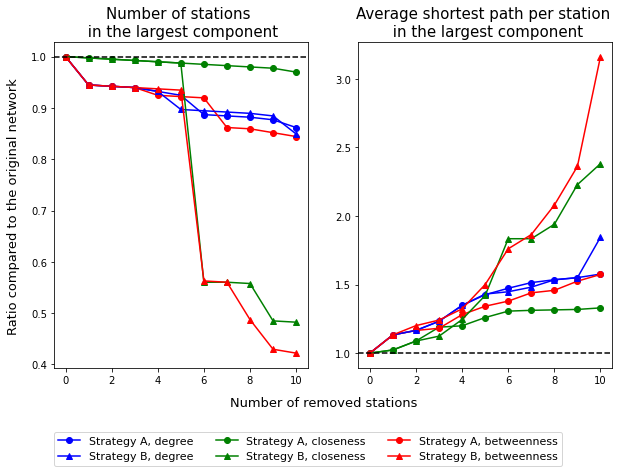

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (10,6))
text = fig.supxlabel('Number of removed stations', y=0.03, fontsize = '13')
text2 = fig.supylabel('Ratio compared to the original network', x=0.06, fontsize = '13')

# 1st subplot
axes[0].set_title('Number of stations \n in the largest component',fontsize = '15')
axes[0].plot(df_degree_A['maxsize_normed'],'-bo', label='Strategy A, degree')
axes[0].plot(df_closeness_A['maxsize_normed'],'-go', label='Strategy A, closeness')
axes[0].plot(df_betweenness_A['maxsize_normed'],'-ro', label='Strategy A, betweenness')
axes[0].plot(df_degree_B['maxsize_normed'],'-b^', label='Strategy B, degree')
axes[0].plot(df_closeness_B['maxsize_normed'],'-g^', label='Strategy B, closeness')
axes[0].plot(df_betweenness_B['maxsize_normed'],'-r^', label='Strategy B, betweenness')
axes[0].axhline(1, linestyle='--', color = 'k')

# 2nd subplot
axes[1].set_title('Average shortest path per station \n in the largest component',fontsize = '15')
axes[1].plot(df_degree_A['avlength per node_normed'],'-bo', label='Strategy A, degree')
axes[1].plot(df_closeness_A['avlength per node_normed'],'-go', label='Strategy A, closeness')
axes[1].plot(df_betweenness_A['avlength per node_normed'],'-ro', label='Strategy A, betweenness')
axes[1].plot(df_degree_B['avlength per node_normed'],'-b^', label='Strategy B, degree')
axes[1].plot(df_closeness_B['avlength per node_normed'],'-g^', label='Strategy B, closeness')
axes[1].plot(df_betweenness_B['avlength per node_normed'],'-r^', label='Strategy B, betweenness')
axes[1].axhline(1, linestyle='--', color = 'k')

# legend
handles, labels = axes[1].get_legend_handles_labels()
order = [0,3,1,4,2,5]
#add legend to plot
legend = axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                       loc=(-1.2, -0.3), ncol=3, fontsize = '11')

fig.savefig('Part 1I Impact calc', bbox_extra_artists=(legend,text,text2), bbox_inches='tight')

### II. Flows: weighted network

#### II.1. Centrality measure

- Use <b>betweenness centrality</b> for this section, as Part 1I showed that this is the most significant measure for spotting vulnerable station shut-downs.
- Incorporate weight = 1/flows, as weight represents distance; i.e. larger value in weight = less strongly connected

In [33]:
# Computing each measures - betweenness centrality
betweenness_w_dict =nx.betweenness_centrality(G, weight = 'inv_flows')
nx.set_node_attributes(G,dict(betweenness_w_dict),'betweenness_w')

In [34]:
# Creating a dataframe with station name and 3 centrality measures
df = pd.DataFrame()
#df['station_name'] = G.nodes()
#df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
#df['topological closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
df['weighted betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))
df['topological betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

In [35]:
# Check the top 10 for degree centrality
df_sorted_bet_w = df.sort_values(["weighted betweenness"], ascending=False)
df_sorted_bet_w[0:10]

,weighted betweenness,topological betweenness
Green Park,0.568902,0.213964
Bank and Monument,0.505209,0.288474
Waterloo,0.409238,0.236992
Westminster,0.377581,0.200884
Liverpool Street,0.336911,0.270703
Stratford,0.331671,0.298351
Bond Street,0.292191,0.141132
Euston,0.283774,0.209004
Oxford Circus,0.269863,0.053484
Warren Street,0.253446,0.042446


Output table:

| Rank | Weighted betweenness centrality || Topological betweenness centrality ||
| -: | -: | :- | -: | :- |
| <b>1</b> | Green Park | 0.5689 | Stratford | 0.2978 |
| <b>2</b> | Bank and Monument  | 0.5052 | Bank and Monument | 0.2905 |
| <b>3</b> | Waterloo | 0.4092 | Liverpool Street | 0.2708 |
| <b>4</b> | Westminster | 0.3776 | King's Cross St. Pancras | 0.2553 |
| <b>5</b> | Liverpool Street | 0.3369 | Waterloo | 0.2439 |
| <b>6</b> | Stratford | 0.3317 | Gren Park |0.2158 |
| <b>7</b> | Bond Street | 0.2922 | Euston | 0.2083 |
| <b>8</b> | Euston | 0.2838 | Westminster | 0.2033 |
| <b>9</b> | Oxford Circus | 0.2699 | Baker Street | 0.1916 |
| <b>10</b> | Warren Street | 0.2534 | Finchley Road | 0.1651 |

*Table 3. Weighted and topological betweenness centrality*

#### II.2. Impact measures - refer to the word doc
- % of flows in the largest component
- Average shortest path (1/flow) per station in the largest component

In [36]:
def passenger_in_maxsize(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    passengers = 0
    for edge in G_maxsub.edges():
        (u,v) = edge
        passengers = passengers + G_maxsub.get_edge_data(u,v)['flows']
    
    return passengers

In [37]:
# This is the total flow
passenger_in_maxsize(G)

9930847

In [38]:
def avg_length_weighted(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    return nx.average_shortest_path_length(G_maxsub, weight = 'inv_flows')

In [39]:
avg_length_weighted(G)

0.0008157978810931205

#### II.3. Node removal

In [40]:
G_rm = G.copy()
G_rm_w = G.copy()

# Initial measure
initial_avg_weighted = avg_length_weighted(G)

# Identify the max centrality node using topological betweenness
centrality_list=[(i[1]['betweenness_t']) for i in G_rm.nodes(data=True)]
max_node=[n for n in G_rm.nodes() if G_rm.nodes[n]['betweenness_t'] == max(centrality_list)][0] # If multiple max centrality nodes, choose one
station_name = [key for key, value in G_rm.nodes(data=True) if G_rm.nodes[key]['betweenness_t'] == max(centrality_list)][0]
print("max centrality to be removed:", max(centrality_list))
print("node name to be removed:", station_name)

# Identify the max centrality node using weighted betweenness
centrality_list_w=[(i[1]['betweenness_w']) for i in G_rm_w.nodes(data=True)]
max_node_w=[n for n in G_rm.nodes() if G_rm_w.nodes[n]['betweenness_w'] == max(centrality_list_w)][0] # If multiple max centrality nodes, choose one
station_name = [key for key, value in G_rm_w.nodes(data=True) if G_rm_w.nodes[key]['betweenness_w'] == max(centrality_list_w)][0]
print("max centrality to be removed:", max(centrality_list_w))
print("node name to be removed:", station_name)

# Remove the node
G_rm.remove_node(max_node)
G_rm_w.remove_node(max_node_w)

# Evaluate the network efficiency
print('Passenger % in the largest component after removing max topological betweenness: ', 
      passenger_in_maxsize(G_rm)/passenger_in_maxsize(G))
print('Passenger % in the largest component after removing max weighted betweenness: ', 
      passenger_in_maxsize(G_rm_w)/passenger_in_maxsize(G))
print('Shortest path: ', avg_length_weighted(G_rm)/initial_avg_weighted)
print('Shortest path 2: ', avg_length_weighted(G_rm_w)/initial_avg_weighted)


max centrality to be removed: 0.298350612436786
node name to be removed: Stratford
max centrality to be removed: 0.5689024467425288
node name to be removed: Green Park
Passenger % in the largest component after removing max topological betweenness:  0.9405905659406494
Passenger % in the largest component after removing max weighted betweenness:  0.9366980480114133
Shortest path:  1.3759995383872259
Shortest path 2:  1.0338363842764386


## Part 2: Spatial interaction models

In [41]:
# Reading in the OD matrix
df_OD = pd.read_csv("london_flows.csv")

In [42]:
df_OD.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [43]:
# Remove entries where orig = dest
df_OD = df_OD.loc[df_OD["station_origin"] != df_OD["station_destination"]]

In [44]:
# Remove entries where orig or dest is Battersea Park
df_OD.drop(df_OD[df_OD["station_origin"] == "Battersea Park"].index, inplace = True)
df_OD.drop(df_OD[df_OD["station_destination"] == "Battersea Park"].index, inplace = True)

#### Pivot table for checking total conservation

In [45]:
# Creating a pivot table from the long list
df_OD_pivot_actual = pd.pivot_table(df_OD, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True).fillna(0)

In [46]:
df_OD_pivot_actual.sort_values(by='All').tail(5)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
London Bridge,0.0,0.0,24.0,20.0,47.0,0.0,9.0,1.0,0.0,905.0,...,0.0,1.0,52.0,1.0,0.0,5.0,0.0,9.0,0.0,32593
Victoria,0.0,0.0,30.0,59.0,153.0,0.0,9.0,2.0,0.0,235.0,...,53.0,2.0,122.0,2.0,0.0,7.0,0.0,26.0,0.0,37517
Stratford,223.0,25.0,7.0,18.0,186.0,157.0,3.0,0.0,0.0,167.0,...,3.0,4.0,43.0,1.0,0.0,133.0,0.0,8.0,1106.0,59311
Waterloo,0.0,0.0,14.0,108.0,381.0,0.0,6.0,1.0,0.0,306.0,...,2.0,0.0,43.0,5.0,0.0,12.0,0.0,18.0,0.0,67314
All,345.0,750.0,2202.0,7782.0,7932.0,444.0,741.0,256.0,173.0,8103.0,...,6295.0,596.0,2146.0,1578.0,404.0,706.0,242.0,745.0,4428.0,1542283


### I. Models

#### 4 types of gravity model

- Unconstrained model: formula = <b> 'Total ~ log_Oi1_origpop + log_Dj2_destsal + log_Dist' <b>
    
\begin{equation} \tag{1}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{2}
\ln T_{ij} = K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij}
\end{equation}

\begin{equation} \tag{3}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

where intercept = K = ln(k), alpha = coef(log_Oi1_origpop), gamma = coef(log_Dj2_destsal), beta = -coef(log_Dist)
<br>

- Production constrained model: <b> 'Total ~ OrigCodeNew + log_Dj2_destsal + log_Dist-1' <b>
    
\begin{equation} \tag{4a}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{4b}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{4c}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{5}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

where　$\alpha_i$ is the equivalent of the vector of balancing factors $A_i$, which is a dummy variable. Alpha includes $O_i$ information as a categorical parameter.

- Attraction constrained model: <b> 'Total ~ DestCodeNew + log_Oi1_origpop + log_Dist-1' <b>
    
\begin{equation} \tag{6a}
T_{ij} = D_j B_j O_i^\alpha d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{6b}
D_j = \sum_i T_{ij}
\end{equation}

\begin{equation} \tag{6c}
B_j = \frac{1}{\sum_i O_i^\alpha d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{7}
\lambda_{ij} = \exp (\alpha \ln O_i + \gamma_i - \beta \ln d_{ij})
\end{equation}

- Doubly constrained model: <b> 'Total ~ Dest + Orig + log_Dist-1' <b>
   
\begin{equation} \tag{8a}
T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta}
\end{equation}

\begin{equation} \tag{8b}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{8c}
D_j = \sum_i T_{ij} 
\end{equation}

\begin{equation} \tag{8d}
A_i = \frac{1}{\sum_j B_j D_j d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{8e}
B_j = \frac{1}{\sum_i A_i O_i d_{ij}^{-\beta}}
\end{equation}
    
\begin{equation} \tag{9}
\lambda_{ij} = \exp (\alpha_i + \gamma_j -\beta \ln d_{ij})
\end{equation}


#### To use negative exponential for distance decay, substitute 'log_Dist' with 'Dist' in formula

\begin{equation} \tag{1'}
T_{ij} = k O_i^\alpha  D_j^\gamma  \exp (-\beta d_{ij})
\end{equation}

\begin{equation} \tag{2'}
\ln T_{ij} = K + \alpha \ln O_i + \gamma \ln D_j - \beta d_{ij}
\end{equation}

\begin{equation} \tag{3'}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta d_{ij})
\end{equation}

In [47]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt

In [48]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    return R2

def CalcRMSE(observed, estimated):    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    return RMSE

In [49]:
# Fitting the model
def model_predict(dataframe, formula):

    #run a model
    model = smf.glm(formula, data=dataframe, family=sm.families.Poisson()).fit()
    predictions = model.get_prediction()
    predictions_summary_frame = predictions.summary_frame()
    
    dataframe[formula] = predictions_summary_frame["mean"]
    
    #round and convert to integers
    dataframe[formula] = round(dataframe[formula], 0)
    dataframe[formula] = dataframe[formula].astype(int)
    
    '''
    #show the results as a pivot table
    pivot_table = dataframe.pivot_table(values =formula, index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
    print(pivot_table)
    '''

    #calculate the metric
    Rsq = CalcRSqaured(cdata["Total"], cdata[formula])
    RMSE = CalcRMSE(cdata["Total"], cdata[formula])
    
#    return (sum(dataframe[formula]), Rsq, RMSE)
    return (sum(dataframe[formula]), Rsq, RMSE, model.summary())

### II. Attraction constrained model calibration

In [50]:
# Create logged variables - population and distance
x_variables = ["population", "distance"]
log_x_vars = []
for x in x_variables:
    df_OD[f"log_{x}"] = np.log(df_OD[x])
    log_x_vars.append(f"log_{x}")

In [51]:
df_OD.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,7.709274


#### Run the model

In [52]:
# Define list of formulas
formula_list = [
    #'Total ~ log_Oi1_origpop + log_Dj2_destsal + log_Dist', # unconstrained power
    #'Total ~ log_Oi1_origpop + log_Dj2_destsal + Dist', # unconstrained exponential
    #'Total ~ OrigCodeNew + log_Dj2_destsal + log_Dist-1', # production constrained power
    #'Total ~ OrigCodeNew + log_Dj2_destsal + Dist-1', # production constrained exponential
    'flows ~ station_destination + log_population + log_distance-1', # attraction constrained power
    'flows ~ station_destination + log_population + distance-1', # attraction constrained exponential
    #'Total ~ DestCodeNew + OrigCodeNew + log_Dist-1', # doubly constrained power
    #'Total ~ DestCodeNew + OrigCodeNew + Dist-1' # doubly constrained exponential
]

In [ ]:
# Run the model -> output: (total, R2, RSME) + parameters
for formula in formula_list:
    print(model_predict(df_OD, formula))

### IV. Scenarios